In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import coremltools
from scipy import stats
from IPython.display import display, HTML
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils

In [2]:
pd.options.display.float_format = "{:.1f}".format # Set some standard parameters upfront
sns.set() # Default seaborn look and feel
plt.style.use("ggplot")
print("Keras version ", keras.__version__)
LABELS = ["Downstairs", "Jogging", "Sitting", "Standing", "Upstairs", "Walking"]
# The number of steps within one time segment
TIME_PERIODS = 80
# The steps to take from one segment to the next; if this value is equal to TIME_PERIODS, then there is
# no overlap between the segments
STEP_DISTANCE = 40

keras version  2.4.3


In [3]:
def read_data(file_path):
    column_names = ["user-id", "activity", "timestamp", "x-axis", "y-axis", "z-axis"]
    df = pd.read_csv(file_path, header = None, names = column_names)
    # Last column has a ";" character which must be removed ...
    df["z-axis"].replace(regex = True, inplace = True, to_replace = r';', value = r'')
    # ... and then this column must be transformed to float explicitly
    df["z-axis"] = df["z-axis"].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss will show up as NAN
    df.dropna(axis=0, how='any', inplace=True)
    return df

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan
    
def show_basic_dataframe_info(dataframe):
    # Shape and how many rows and columns
    print("Number of columns in the dataframe: %i" % (dataframe.shape[1]))
    print("Number of rows in the dataframe: %i\n" % (dataframe.shape[0]))

# Load data set containing all the data from csv
df = read_data("./WISDM_ar_latest/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt")

In [4]:
# Describe the data
show_basic_dataframe_info(df)
df.head(20)

Number of columns in the dataframe: 6
Number of rows in the dataframe: 1098203



,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.7,12.7,0.5
1,33,Jogging,49106062271000,5.0,11.3,1.0
2,33,Jogging,49106112167000,4.9,10.9,-0.1
3,33,Jogging,49106222305000,-0.6,18.5,3.0
4,33,Jogging,49106332290000,-1.2,12.1,7.2
5,33,Jogging,49106442306000,1.4,-2.5,-6.5
6,33,Jogging,49106542312000,-0.6,10.6,5.7
7,33,Jogging,49106652389000,-0.5,13.9,7.1
8,33,Jogging,49106762313000,-8.4,11.4,5.1
9,33,Jogging,49106872299000,1.0,1.4,1.6


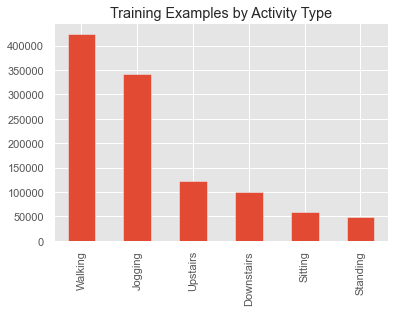

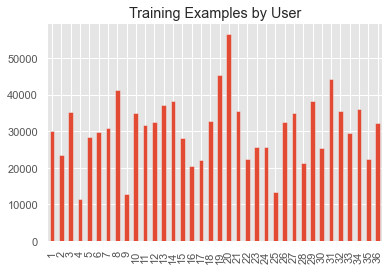

In [5]:
# Show how many training examples exist for each of the six activities
df["activity"].value_counts().plot(kind = "bar", title = "Training Examples by Activity Type")
plt.show()
# Better understand how the recordings are spread across the different users who participated in the study
df["user-id"].value_counts().plot(kind = "bar", title = "Training Examples by User")
plt.show()

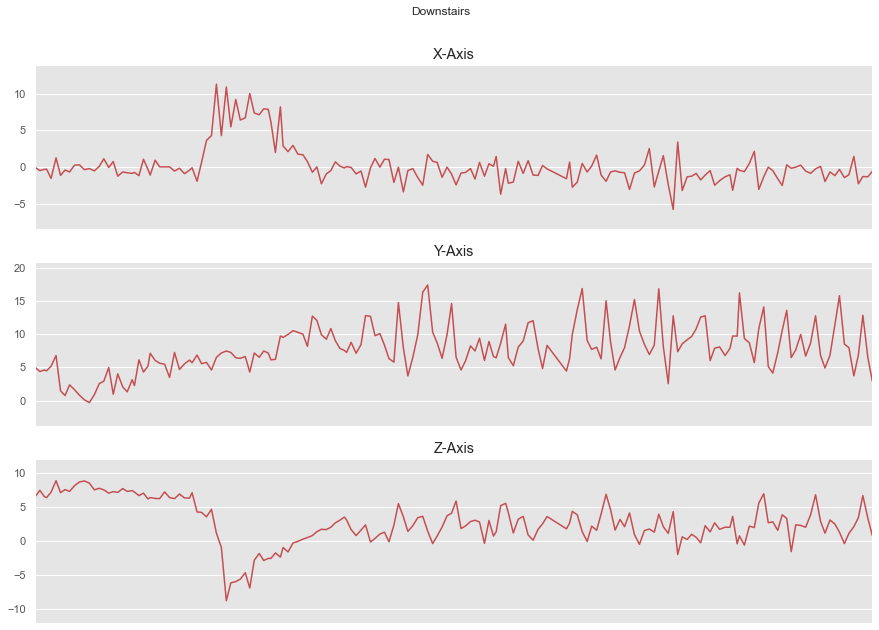

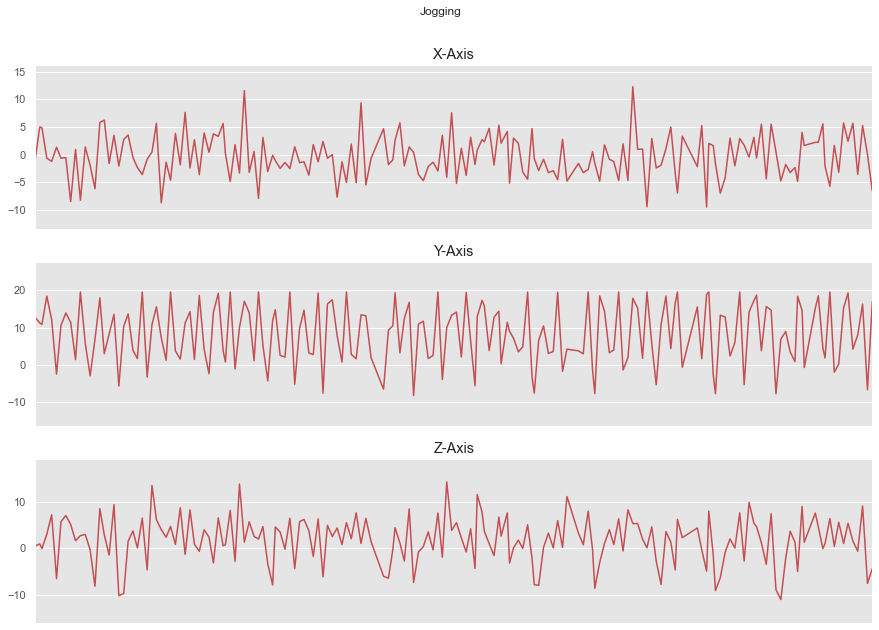

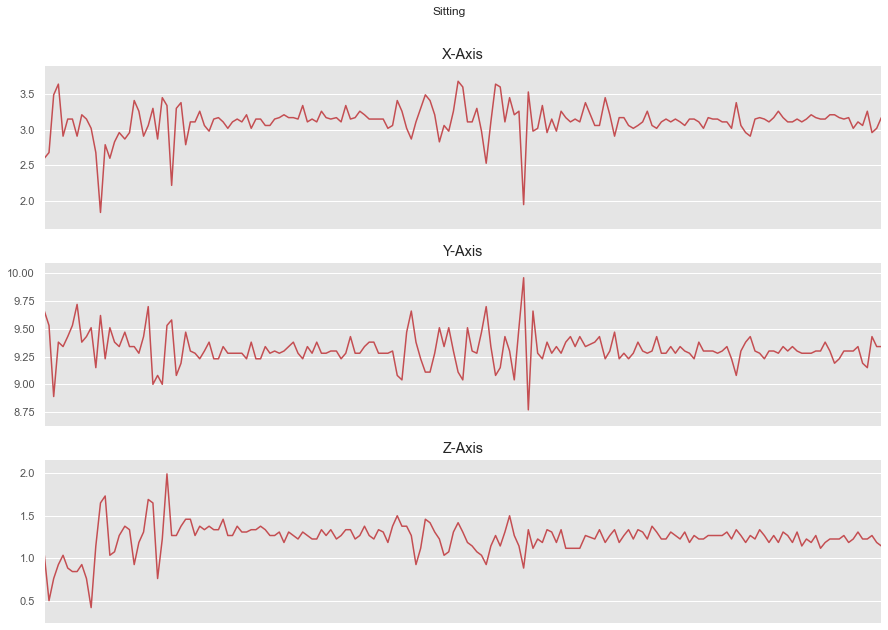

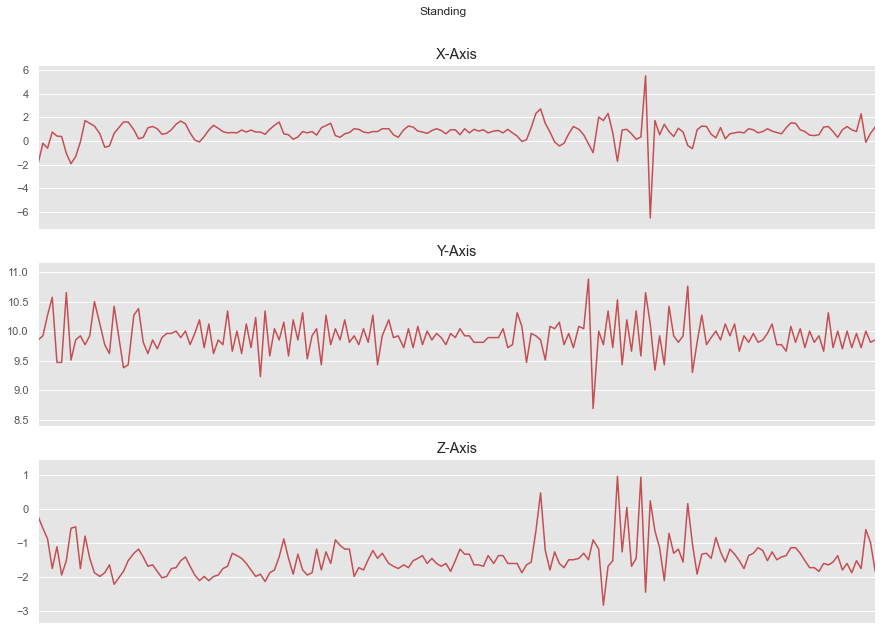

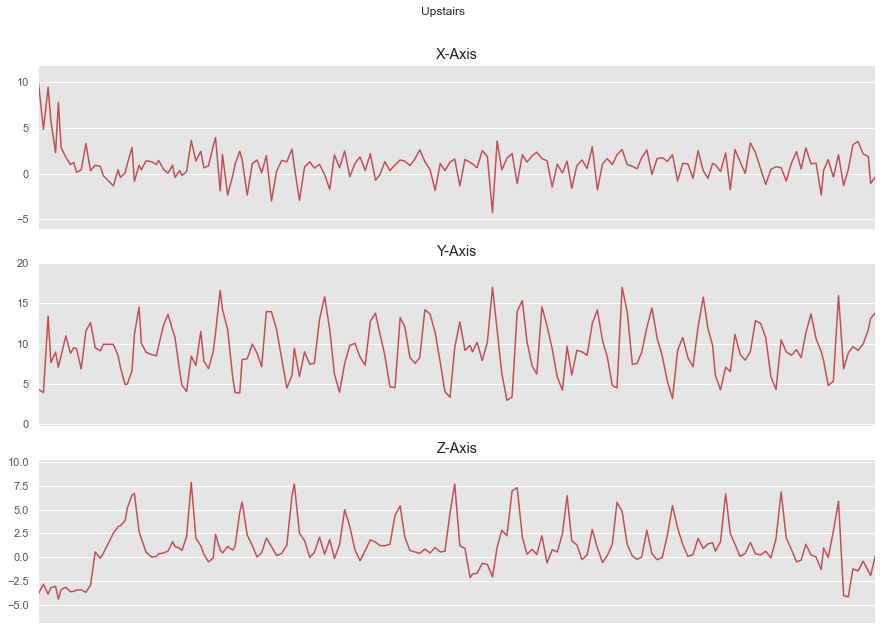

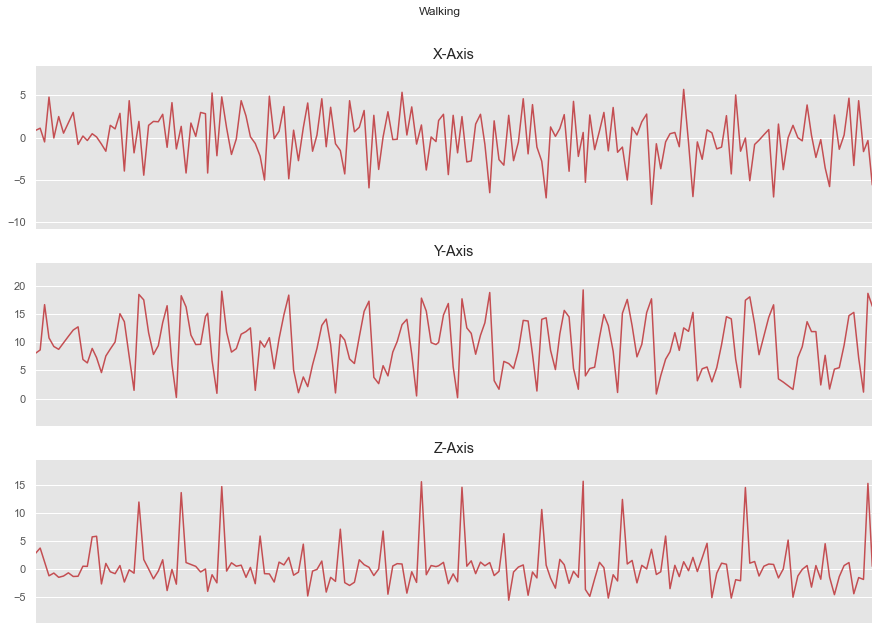

In [6]:
def plot_activity(activity, data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows = 3, figsize = (15, 10), sharex = True)
    plot_axis(ax0, data["timestamp"], data["x-axis"], "X-Axis")
    plot_axis(ax1, data["timestamp"], data["y-axis"], "Y-Axis")
    plot_axis(ax2, data["timestamp"], data["z-axis"], "Z-Axis")
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in np.unique(df["activity"]):
    subset = df[df["activity"] == activity][:180]
    plot_activity(activity, subset)

In [7]:
# Define column name of the label vector
LABEL = "ActivityEncoded"
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df[LABEL] = le.fit_transform(df["activity"].values.ravel())

In [8]:
# Differentiate between test set and training set
df_test = df[df["user-id"] > 28]
df_train = df[df["user-id"] <= 28]

In [9]:
# Normalize features for training data set (values between 0 and 1)
# Surpress warning for next 3 operation
pd.options.mode.chained_assignment = None  # default='warn'
df_train["x-axis"] = df_train["x-axis"] / df_train["x-axis"].max()
df_train["y-axis"] = df_train["y-axis"] / df_train["y-axis"].max()
df_train["z-axis"] = df_train["z-axis"] / df_train["z-axis"].max()
# Round numbers
df_train = df_train.round({"x-axis": 4, "y-axis": 4, "z-axis": 4})

In [10]:
def create_segments_and_labels(df, time_steps, step, label_name):
    # x, y, z acceleration as features
    N_FEATURES = 3
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df["x-axis"].values[i: i + time_steps]
        ys = df["y-axis"].values[i: i + time_steps]
        zs = df["z-axis"].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)
    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)
    return reshaped_segments, labels

x_train, y_train = create_segments_and_labels(df_train, TIME_PERIODS, STEP_DISTANCE, LABEL)

In [11]:
print("x_train shape: ", x_train.shape)
print(x_train.shape[0], 'training samples')
print("y_train shape: ", y_train.shape)

x_train shape:  (20868, 80, 3)
20868 training samples
y_train shape:  (20868,)


In [12]:
# Set input & output dimensions
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
num_classes = le.classes_.size
print(list(le.classes_))

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']


In [13]:
input_shape = (num_time_periods*num_sensors)
x_train = x_train.reshape(x_train.shape[0], input_shape)
print("x_train shape: ", x_train.shape)
print("input_shape: ", input_shape)

x_train shape: (20868, 240)
input_shape: 240


In [14]:
x_train = x_train.astype("float32")
y_train = y_train.astype("float32")

In [15]:
y_train_hot = np_utils.to_categorical(y_train, num_classes)
print("New y_train shape: ", y_train_hot.shape)

New y_train shape:  (20868, 6)


In [16]:
model_m = Sequential()
# Remark: since coreml cannot accept vector shapes of complex shape like
# [80,3] this workaround is used in order to reshape the vector internally
# prior feeding it into the network
model_m.add(Reshape((TIME_PERIODS, 3), input_shape = (input_shape,)))
model_m.add(Dense(100, activation = "relu"))
model_m.add(Dense(100, activation = "relu"))
model_m.add(Dense(100, activation = "relu"))
model_m.add(Flatten())
model_m.add(Dense(num_classes, activation = "softmax"))
print(model_m.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 80, 3)             0         
_________________________________________________________________
dense (Dense)                (None, 80, 100)           400       
_________________________________________________________________
dense_1 (Dense)              (None, 80, 100)           10100     
_________________________________________________________________
dense_2 (Dense)              (None, 80, 100)           10100     
_________________________________________________________________
flatten (Flatten)            (None, 8000)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 48006     
Total params: 68,606
Trainable params: 68,606
Non-trainable params: 0
____________________________________________________

In [17]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath = "best_model.{epoch:02d}-{val_loss:.2f}.h5",
        monitor = "val_loss", save_best_only = True),
    keras.callbacks.EarlyStopping(monitor = "acc", patience = 1)
]

model_m.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

# Hyper-parameters
BATCH_SIZE = 400
EPOCHS = 50

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train, y_train_hot, batch_size = BATCH_SIZE, epochs = EPOCHS,
                      callbacks = callbacks_list, validation_split = 0.2, verbose = 1)

Epoch 1/50
42/42 [==============================] - 4s 94ms/step - loss: 1.3098 - accuracy: 0.5529 - val_loss: 0.6991 - val_accuracy: 0.8165
Epoch 2/50
42/42 [==============================] - 3s 82ms/step - loss: 0.6096 - accuracy: 0.7887 - val_loss: 0.6407 - val_accuracy: 0.8218
Epoch 3/50
42/42 [==============================] - 3s 80ms/step - loss: 0.5264 - accuracy: 0.8086 - val_loss: 0.6191 - val_accuracy: 0.8306
Epoch 4/50
42/42 [==============================] - 3s 82ms/step - loss: 0.4962 - accuracy: 0.8177 - val_loss: 0.6426 - val_accuracy: 0.8079
Epoch 5/50
42/42 [==============================] - 4s 84ms/step - loss: 0.4572 - accuracy: 0.8355 - val_loss: 0.6471 - val_accuracy: 0.7882
Epoch 6/50
42/42 [==============================] - 4s 88ms/step - loss: 0.4419 - accuracy: 0.8360 - val_loss: 0.6706 - val_accuracy: 0.7873
Epoch 7/50
42/42 [==============================] - 4s 85ms/step - loss: 0.4212 - accuracy: 0.8498 - val_loss: 0.6848 - val_accuracy: 0.7755
Epoch 8/50
42

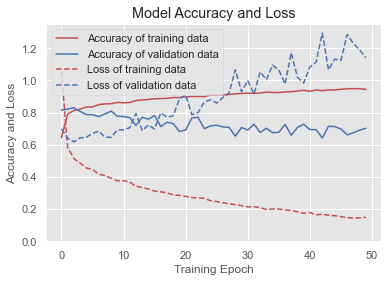

              precision    recall  f1-score   support

         0.0       0.76      0.62      0.68      1864
         1.0       0.98      0.97      0.98      6567
         2.0       0.99      1.00      1.00      1050
         3.0       1.00      0.99      0.99       833
         4.0       0.68      0.77      0.72      2342
         5.0       0.91      0.92      0.91      8212

    accuracy                           0.90     20868
   macro avg       0.89      0.88      0.88     20868
weighted avg       0.90      0.90      0.90     20868



In [18]:
plt.figure(figsize=(6, 4))
plt.plot(history.history["accuracy"], 'r', label = "Accuracy of training data")
plt.plot(history.history["val_accuracy"], 'b', label = "Accuracy of validation data")
plt.plot(history.history["loss"], 'r--', label = "Loss of training data")
plt.plot(history.history["val_loss"], 'b--', label = "Loss of validation data")
plt.title("Model Accuracy and Loss")
plt.ylabel("Accuracy and Loss")
plt.xlabel("Training Epoch")
plt.ylim(0)
plt.legend()
plt.show()

# Print confusion matrix for training data
y_pred_train = model_m.predict(x_train)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis = 1)
print(classification_report(y_train, max_y_pred_train))